In [263]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn

from sklearn.pipeline import make_pipeline

from IPython.display import display

%matplotlib inline

In [264]:
# Зареждам данните и оглеждам колоните
data = pd.read_csv('pokemon_alopez247.csv', index_col=['Number'])
original = data.copy()
data.describe()

,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,Pr_Male,Height_m,Weight_kg,Catch_Rate
count,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,644.000000,721.000000,721.000000,721.000000
mean,417.945908,68.380028,75.013870,70.808599,68.737864,69.291262,65.714286,3.323162,0.553377,1.144979,56.773370,100.246879
std,109.663671,25.848272,28.984475,29.296558,28.788005,27.015860,27.277920,1.669873,0.199969,1.044369,89.095667,76.573513
min,180.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.000000,0.000000,0.100000,0.100000,3.000000
25%,320.000000,50.000000,53.000000,50.000000,45.000000,50.000000,45.000000,2.000000,0.500000,0.610000,9.400000,45.000000
50%,424.000000,65.000000,74.000000,65.000000,65.000000,65.000000,65.000000,3.000000,0.500000,0.990000,28.000000,65.000000
75%,499.000000,80.000000,95.000000,85.000000,90.000000,85.000000,85.000000,5.000000,0.500000,1.400000,61.000000,180.000000
max,720.000000,255.000000,165.000000,230.000000,154.000000,230.000000,160.000000,6.000000,1.000000,14.500000,950.000000,255.000000


In [265]:
data.head()
data.columns
data.isnull().sum().sort_values() 
#За да видим кои колони ще се наложи да запълним преди да можем да направим прост модел

Name                  0
Weight_kg             0
Height_m              0
hasMegaEvolution      0
Egg_Group_1           0
hasGender             0
Color                 0
isLegendary           0
Catch_Rate            0
Generation            0
Sp_Def                0
Sp_Atk                0
Defense               0
Attack                0
HP                    0
Total                 0
Type_1                0
Speed                 0
Body_Style            0
Pr_Male              77
Type_2              371
Egg_Group_2         530
dtype: int64

In [266]:
#Запълвам празните клетки по абсолютно най-простия начин и проверявам дали всичко е готово
data['Pr_Male'] = data.Pr_Male.fillna(data['Pr_Male'].mean())
data['Type_2'] = data.Type_2.fillna("UnknownType")
data['Egg_Group_2'] = data.Type_2.fillna("UnknowEggGroup2")

data.isnull().sum().sort_values()

Name                0
Weight_kg           0
Height_m            0
hasMegaEvolution    0
Egg_Group_2         0
Egg_Group_1         0
Pr_Male             0
hasGender           0
Color               0
isLegendary         0
Generation          0
Speed               0
Sp_Def              0
Sp_Atk              0
Defense             0
Attack              0
HP                  0
Total               0
Type_2              0
Type_1              0
Catch_Rate          0
Body_Style          0
dtype: int64

In [267]:
# Правя бейслайн модел с числовите колони
from sklearn.model_selection import train_test_split

numeric_column_names = ['Total', 'HP', 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'Speed', 'Generation', 
          'isLegendary', 'Height_m', 'Weight_kg', 'hasMegaEvolution']

y = pd.DataFrame(data['Catch_Rate'])
X = data[numeric_column_names]


# Понеже има стойности в y, които се срещат смао веднъж и train_test_split ни се кара
single_count = [160, 70, 80, 205, 35, 145, 15, 155]
for val in single_count:
    y.loc[y.Catch_Rate == val] = 80

y = y['Catch_Rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

train score: 0.54663851173
test score:  0.554192609282


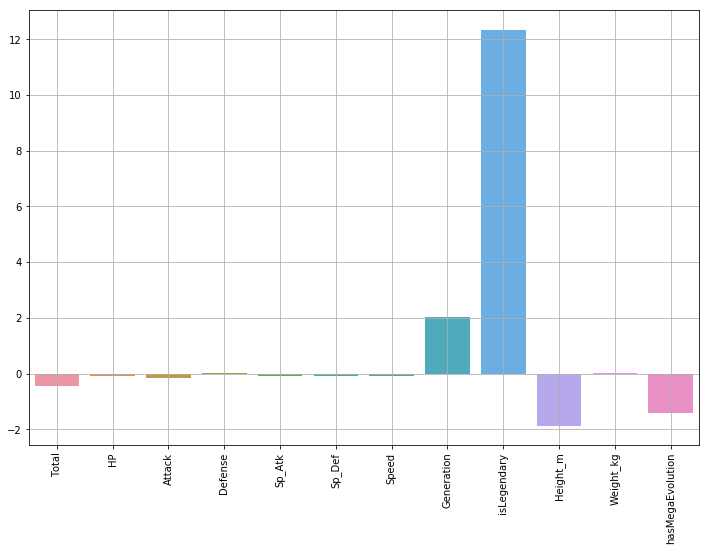

In [268]:
# Първо пробвам с линейна регресия
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X_train, y_train)
print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

plt.figure(figsize=(12,8))
barplot = sns.barplot(x=numeric_column_names, y=model.coef_, orient='vertical')
plt.setp(barplot.get_xticklabels(), rotation=90); plt.grid(True);

In [269]:
# Ред е на random forest - той оувърфитва доста
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=0).fit(X_train, y_train)
print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))
# стабилно overfit-на

train score: 0.934700540978
test score:  0.636405909115


In [270]:
# Затова пробвам да го регуляризирам
from sklearn.model_selection import GridSearchCV

search = GridSearchCV(model, {'n_estimators': [10, 30, 50, 70, 100],
                              'max_depth': [2, 4, 6, 8, 10, 12, 15]})
search.fit(X, y)

pd.DataFrame(search.cv_results_)[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(10)

,rank_test_score,mean_test_score,params
14,1,0.601315,"{'max_depth': 6, 'n_estimators': 100}"
13,2,0.599328,"{'max_depth': 6, 'n_estimators': 70}"
12,3,0.598555,"{'max_depth': 6, 'n_estimators': 50}"
19,4,0.596983,"{'max_depth': 8, 'n_estimators': 100}"
29,5,0.596851,"{'max_depth': 12, 'n_estimators': 100}"
24,6,0.596709,"{'max_depth': 10, 'n_estimators': 100}"
18,7,0.596282,"{'max_depth': 8, 'n_estimators': 70}"
28,8,0.596218,"{'max_depth': 12, 'n_estimators': 70}"
9,9,0.595767,"{'max_depth': 4, 'n_estimators': 100}"
34,10,0.595148,"{'max_depth': 15, 'n_estimators': 100}"


In [271]:
model = RandomForestRegressor(random_state=0, n_estimators=100, max_depth=6).fit(X_train, y_train)
print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))
#отново overfit-ва (въпреки, че по-малко), но е малко по-добре на тест (което може би е хиперпараметри овърфит, кой знае)

train score: 0.82779888163
test score:  0.673338775523


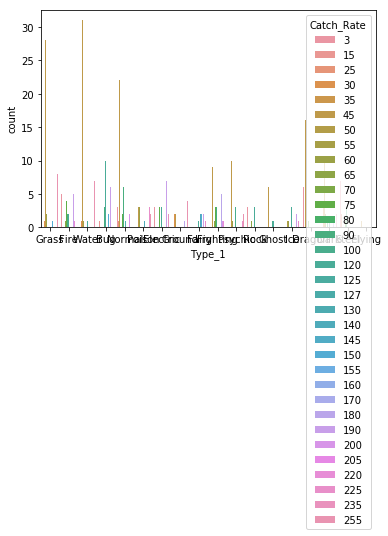

In [272]:
# ще потърся дали стринг колоните, които изключих биха ми дали добра насока
import seaborn as sns
sns.countplot('Type_1', hue='Catch_Rate', data=data);

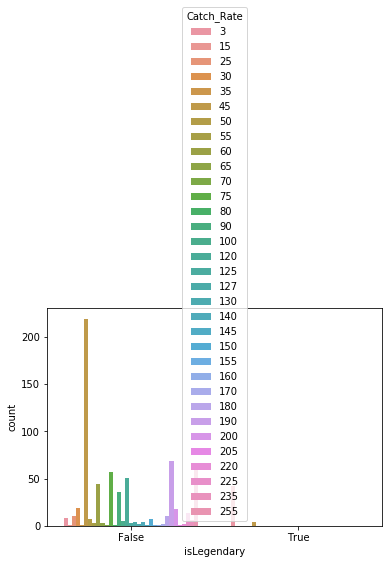

In [273]:
sns.countplot('isLegendary', hue='Catch_Rate', data=data)
# vijdam che isLegendary colonata ni dava dobra nasoka za catch rate

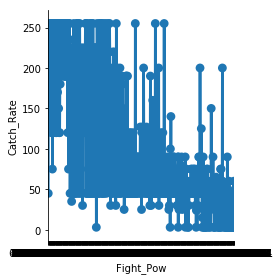

In [274]:
# Правя си нов фийчър. Четох в разни форуми как реално протича битката и ми се струва, че това би ми дало някаква полза
# След като го направя искам да видя на графика дали реално получавам някаква информация от него.
data['Fight_Pow'] = np.log (data.Attack * data.HP + data.Defense * data.HP + data.Sp_Atk * data.Sp_Def + data.Height_m * data.Weight_kg * data.Speed)

result = data.sort_values(by='Fight_Pow', ascending=True)
sns.factorplot('Fight_Pow', 'Catch_Rate', data=data)
# За по-малки и по-големи стойности ми дава добра насока за catch rate

In [275]:
# добавям някои по-смислени стринг фийчъри плюс новия фийчър - Fight_Pow
# оне-хот енкодвам стринг фийчърите
non_categorical_cols = ['Total', 'HP', 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'Speed', 'Generation', 
          'isLegendary', 'Height_m', 'Weight_kg', 'hasMegaEvolution', 'Pr_Male', 'hasGender', 'Fight_Pow',]
X = data[non_categorical_cols]

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
categorical_columns = ['Type_1', 'Type_2', 'Egg_Group_2', 'Egg_Group_1', 'Color']

def encode_categorical(data, columns, encoders):
    data = data.fillna("")
    return pd.DataFrame({col: encoders[col].transform(data[col]) for col in columns},
                        index = data.index)
data = data.fillna("")
encoders = {col: LabelEncoder().fit(data[col]) for col in categorical_columns}
label_encoded = encode_categorical(data, categorical_columns, encoders)

one_hot_encoder = OneHotEncoder().fit(label_encoded)
one_hot_encoded = one_hot_encoder.transform(label_encoded)
encoded_data = pd.np.concatenate([one_hot_encoded.todense(), X], axis=1)

In [276]:
# все още оувърфитва, но пък има значително по-висок тест тезултат, 
#train score: 0.914717018056
#test score:  0.752358252354
X_train, X_test, y_train, y_test = train_test_split(encoded_data, y, random_state=0, stratify=y)
model_encoded = RandomForestRegressor(random_state=0, n_estimators=100, max_depth=15).fit(X_train, y_train)
print("train score:", model_encoded.score(X_train, y_train))
print("test score: ", model_encoded.score(X_test, y_test))

# пробвах и с Линейна Регресия, но тя се държеше доста по-зле, въпреки че не оувърфитва
from sklearn.linear_model import Ridge
model_encoded_2 = Ridge().fit(X_train, y_train)
print("train score Ridge:", model_encoded_2.score(X_train, y_train))
print("test score Ridge: ", model_encoded_2.score(X_test, y_test))



search = GridSearchCV(model_encoded, {'n_estimators': [10, 30, 50, 70, 100],
                              'max_depth': [2, 4, 6, 8, 10, 12, 15]})
search.fit(encoded_data, y)

pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score').head(10)


train score: 0.952825019612
test score:  0.759748933736
train score Ridge: 0.637684739953
test score Ridge:  0.626440743811


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
28,0.394694,0.005999,0.669213,0.950071,12,70,"{'max_depth': 12, 'n_estimators': 70}",1,0.649566,0.950604,0.636192,0.956168,0.721962,0.943441,0.071928,0.002112,0.037659,0.005210
29,0.592299,0.006199,0.668023,0.950547,12,100,"{'max_depth': 12, 'n_estimators': 100}",2,0.655615,0.950615,0.631709,0.956054,0.716797,0.944972,0.199084,0.000277,0.035809,0.004524
33,0.489676,0.018852,0.667687,0.953853,15,70,"{'max_depth': 15, 'n_estimators': 70}",3,0.650399,0.953888,0.632887,0.958772,0.719849,0.948898,0.266378,0.018531,0.037533,0.004031
34,0.505071,0.010393,0.665308,0.954464,15,100,"{'max_depth': 15, 'n_estimators': 100}",4,0.652947,0.954823,0.628084,0.958920,0.714943,0.949649,0.104559,0.002786,0.036502,0.003793
24,0.409791,0.008966,0.664581,0.941536,10,100,"{'max_depth': 10, 'n_estimators': 100}",5,0.655061,0.940829,0.627701,0.947919,0.711019,0.935860,0.080252,0.003862,0.034654,0.004949
23,0.265010,0.006100,0.664489,0.940842,10,70,"{'max_depth': 10, 'n_estimators': 70}",6,0.648379,0.940504,0.631454,0.948115,0.713701,0.933906,0.019487,0.002206,0.035442,0.005806
19,0.730867,0.011353,0.662850,0.918845,8,100,"{'max_depth': 8, 'n_estimators': 100}",7,0.652196,0.916197,0.628864,0.928404,0.707535,0.911933,0.201487,0.005474,0.032971,0.006980
18,0.199284,0.004218,0.661987,0.918437,8,70,"{'max_depth': 8, 'n_estimators': 70}",8,0.643002,0.916961,0.632851,0.928145,0.710186,0.910205,0.005429,0.000044,0.034298,0.007398
32,0.286855,0.003867,0.661842,0.952782,15,50,"{'max_depth': 15, 'n_estimators': 50}",9,0.638919,0.954654,0.626849,0.957953,0.719854,0.945740,0.042752,0.000203,0.041273,0.005159
27,0.189137,0.005099,0.661683,0.948709,12,50,"{'max_depth': 12, 'n_estimators': 50}",10,0.635313,0.950604,0.629260,0.955104,0.720587,0.940418,0.019096,0.001842,0.041681,0.006143


In [277]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_features.fit(X_train)

poly_x_train = poly_features.transform(X_train)
poly_x_test = poly_features.transform(X_test)

print(X_train.shape)
print(poly_x_train.shape)

(540, 96)
(540, 4656)


In [278]:
# полиномните фийчъри не помогнаха особено
model_encoded = RandomForestRegressor(random_state=0, n_estimators=70, max_depth=15).fit(poly_x_train, y_train)
print("train score:", model_encoded.score(poly_x_train, y_train))
print("test score: ", model_encoded.score(poly_x_test, y_test))


train score: 0.951919633113
test score:  0.722560178246


In [279]:
# Както видяхме Fight_Pow не е линеен фийчър и затова реших да го категоризирам. 
# Поколенията също са лейбъли от 1 до 6, така че и тях
non_categorical_cols = ['Total', 'Speed', 'isLegendary', 'Height_m', 'Weight_kg', 'hasMegaEvolution', 'Pr_Male']    
data['Fight_Pow_Categorical'] = data['Fight_Pow'].astype(int)

X = data[non_categorical_cols]
categorical_columns = ['Type_1', 'Type_2', 'Egg_Group_2', 'Egg_Group_1', 'Color', 'Fight_Pow_Categorical', 'Generation']

encoders = {col: LabelEncoder().fit(data[col]) for col in categorical_columns}
label_encoded = encode_categorical(data, categorical_columns, encoders)

one_hot_encoder = OneHotEncoder().fit(label_encoded)
one_hot_encoded = one_hot_encoder.transform(label_encoded)
encoded_data = pd.np.concatenate([one_hot_encoded.todense(), X], axis=1)

X_train, X_test, y_train, y_test = train_test_split(encoded_data, y, random_state=0, stratify=y)
model_encoded = RandomForestRegressor(random_state=0, n_estimators=100, max_depth=15).fit(X_train, y_train)
print("train score:", model_encoded.score(X_train, y_train))
print("test score: ", model_encoded.score(X_test, y_test))

from sklearn.linear_model import Ridge
model_encoded_2 = Ridge().fit(X_train, y_train)
print("train score Ridge:", model_encoded_2.score(X_train, y_train))
print("test score Ridge: ", model_encoded_2.score(X_test, y_test))


#train score: 0.952037537978
#test score:  0.770861723466
#train score Ridge: 0.65817217655
#test score Ridge:  0.645644402902


train score: 0.952037537978
test score:  0.770861723466
train score Ridge: 0.65817217655
test score Ridge:  0.645644402902


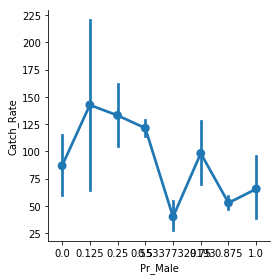

In [280]:
#искам да видя как процента на мъжките покемони влияе на рейта
sns.factorplot('Pr_Male', 'Catch_Rate', data=data)

In [281]:
# изглежда смислено да направим някаква категоризация по него
data['Pr_Male_Categorical'] = (data['Pr_Male'] * 10).astype(int)
data.head()

,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,...,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style,Fight_Pow,Fight_Pow_Categorical,Pr_Male_Categorical
Number,,,,,,,,,,,,,,,,,,,,,
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,...,Monster,Poison,False,0.71,6.9,45,quadruped,9.088789,9,8
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,...,Monster,Poison,False,0.99,13.0,45,quadruped,9.593710,9,8
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,...,Monster,Poison,True,2.01,100.0,45,quadruped,10.578471,10,8
4,Charmander,Fire,UnknownType,309,39,52,43,60,50,65,...,Monster,UnknownType,False,0.61,8.5,45,bipedal_tailed,8.859651,8,8
5,Charmeleon,Fire,UnknownType,405,58,64,58,80,65,80,...,Monster,UnknownType,False,1.09,19.0,45,bipedal_tailed,9.542001,9,8


In [282]:
non_categorical_cols = ['Total', 'Speed', 'isLegendary', 'Height_m', 'Weight_kg', 'hasMegaEvolution']    

X = data[non_categorical_cols]
categorical_columns = ['Type_1', 'Egg_Group_1', 'Color', 'Fight_Pow_Categorical', 'Generation', 'Pr_Male_Categorical']

encoders = {col: LabelEncoder().fit(data[col]) for col in categorical_columns}
label_encoded = encode_categorical(data, categorical_columns, encoders)

one_hot_encoder = OneHotEncoder().fit(label_encoded)
one_hot_encoded = one_hot_encoder.transform(label_encoded)
encoded_data = pd.np.concatenate([one_hot_encoded.todense(), X], axis=1)

X_train, X_test, y_train, y_test = train_test_split(encoded_data, y, random_state=0, stratify=y)
model_encoded = RandomForestRegressor(random_state=0, n_estimators=70, max_depth=15).fit(X_train, y_train)
print("train score:", model_encoded.score(X_train, y_train))
print("test score: ", model_encoded.score(X_test, y_test))

from sklearn.linear_model import Ridge
model_encoded_2 = Ridge().fit(X_train, y_train)
print("train score Ridge:", model_encoded_2.score(X_train, y_train))
print("test score Ridge: ", model_encoded_2.score(X_test, y_test))

search = GridSearchCV(model_encoded, {'n_estimators': [10, 30, 50, 70, 100],
                              'max_depth': [2, 4, 6, 8, 10, 12, 15]})
search.fit(encoded_data, y)

pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score').head(10)

# Категоризирането на процента на мъжките увеличи точноста на линейната регресия. Тя не оувърфитва, средния резултат на 
# тест е съвсем малко по-висок


train score: 0.95085592765
test score:  0.764672592934
train score Ridge: 0.681293274767
test score Ridge:  0.678075310765


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
33,0.337401,0.009071,0.677939,0.952967,15,70,"{'max_depth': 15, 'n_estimators': 70}",1,0.685182,0.951980,0.648367,0.955586,0.700238,0.951334,0.038179,0.003576,0.021775,0.001871
34,0.482451,0.011266,0.677767,0.953522,15,100,"{'max_depth': 15, 'n_estimators': 100}",2,0.683813,0.953343,0.650792,0.956133,0.698671,0.951090,0.200569,0.003312,0.019998,0.002062
28,0.620159,0.020391,0.677765,0.946655,12,70,"{'max_depth': 12, 'n_estimators': 70}",3,0.683736,0.945178,0.653868,0.950250,0.695665,0.944537,0.310102,0.003912,0.017569,0.002556
29,0.441486,0.011100,0.677050,0.947058,12,100,"{'max_depth': 12, 'n_estimators': 100}",4,0.682580,0.946596,0.654107,0.950318,0.694441,0.944260,0.157908,0.005926,0.016915,0.002495
24,0.287739,0.012169,0.675707,0.933617,10,100,"{'max_depth': 10, 'n_estimators': 100}",5,0.682612,0.932861,0.649002,0.938079,0.695478,0.929911,0.074512,0.007312,0.019582,0.003377
23,0.188489,0.004855,0.673680,0.933582,10,70,"{'max_depth': 10, 'n_estimators': 70}",6,0.681340,0.932509,0.643121,0.938511,0.696547,0.929725,0.017410,0.000713,0.022462,0.003666
27,0.326145,0.009148,0.673533,0.945812,12,50,"{'max_depth': 12, 'n_estimators': 50}",7,0.675855,0.945460,0.655233,0.949257,0.689502,0.942720,0.066598,0.001692,0.014077,0.002680
13,0.114777,0.003898,0.671960,0.848825,6,70,"{'max_depth': 6, 'n_estimators': 70}",8,0.696073,0.843808,0.624145,0.861749,0.695561,0.840917,0.001084,0.000347,0.033775,0.009215
18,0.153751,0.004356,0.671717,0.904274,8,70,"{'max_depth': 8, 'n_estimators': 70}",9,0.682636,0.901750,0.635393,0.910811,0.697076,0.900259,0.023243,0.000379,0.026327,0.004663
32,0.335173,0.007712,0.671466,0.951586,15,50,"{'max_depth': 15, 'n_estimators': 50}",10,0.676844,0.951710,0.647080,0.954434,0.690451,0.948613,0.145454,0.001272,0.018099,0.002378


In [335]:
# Реших да пробвам и да прекарам фичърите през PCA и да ги дам на SVC, но той се представи зле
from sklearn.decomposition import PCA
from sklearn.svm import SVR

pca = PCA(n_components=12)
pca.fit(X_train)

X_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

model_encoded = SVR(C=1000000, gamma=0.000005).fit(X_pca, y_train)
print("train score:", model_encoded.score(X_pca, y_train))
print("test score: ", model_encoded.score(X_test_pca, y_test))

train score: 0.613497578046
test score:  0.608071951679


In [284]:
# Последното нещо, което ще направя е да клъстеризирам и да използвам клъстерите за фийчър
from sklearn.cluster import AgglomerativeClustering


dbscan = AgglomerativeClustering(n_clusters=20)
clusters = dbscan.fit_predict(encoded_data)

data['Cluster'] = clusters

data.head()

,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,...,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style,Fight_Pow,Fight_Pow_Categorical,Pr_Male_Categorical,Cluster
Number,,,,,,,,,,,,,,,,,,,,,
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,...,Poison,False,0.71,6.9,45,quadruped,9.088789,9,8,9
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,...,Poison,False,0.99,13.0,45,quadruped,9.593710,9,8,3
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,...,Poison,True,2.01,100.0,45,quadruped,10.578471,10,8,16
4,Charmander,Fire,UnknownType,309,39,52,43,60,50,65,...,UnknownType,False,0.61,8.5,45,bipedal_tailed,8.859651,8,8,9
5,Charmeleon,Fire,UnknownType,405,58,64,58,80,65,80,...,UnknownType,False,1.09,19.0,45,bipedal_tailed,9.542001,9,8,3


In [285]:
# Клъстеризирането вдигна с още процент и налко точността на линейната регресия

non_categorical_cols = ['Total', 'Speed', 'isLegendary', 'Height_m', 'Weight_kg', 'hasMegaEvolution', 'Pr_Male']    
data['Fight_Pow_Categorical'] = data['Fight_Pow'].astype(int)

X = data[non_categorical_cols]
categorical_columns = ['Type_1', 'Egg_Group_1', 'Color', 'Fight_Pow_Categorical', 'Generation', 'Cluster']

encoders = {col: LabelEncoder().fit(data[col]) for col in categorical_columns}
label_encoded = encode_categorical(data, categorical_columns, encoders)

one_hot_encoder = OneHotEncoder().fit(label_encoded)
one_hot_encoded = one_hot_encoder.transform(label_encoded)
encoded_data = pd.np.concatenate([one_hot_encoded.todense(), X], axis=1)

X_train, X_test, y_train, y_test = train_test_split(encoded_data, y, random_state=0, stratify=y)
model_encoded = RandomForestRegressor(random_state=0, n_estimators=100, max_depth=15).fit(X_train, y_train)
print("train score:", model_encoded.score(X_train, y_train))
print("test score: ", model_encoded.score(X_test, y_test))

from sklearn.linear_model import Ridge
model_encoded_2 = Ridge().fit(X_train, y_train)
print("train score Ridge:", model_encoded_2.score(X_train, y_train))
print("test score Ridge: ", model_encoded_2.score(X_test, y_test))


train score: 0.953323570416
test score:  0.765565298008
train score Ridge: 0.691104145169
test score Ridge:  0.689639125159
